In [1]:
class Node:
    def __init__(self,id, minCharAscii = ord('$'), maxCharAscii= ord('~')) -> None:
        """ 
        text[start:end], end is inclusive
        """
        self.start =None
        self.end = None
        self.children = (maxCharAscii+1- minCharAscii) * [None]
        self.minCharAscii = minCharAscii
        self.maxCharAscii = maxCharAscii
        self.suffixLink = None
        self.id =id 
    @property
    def end_value(self):
        return self.end[0] if self.end is not None else None
    def __getCharIndex(self, char):
        return ord(char)-self.minCharAscii
    
    def __setitem__(self, key:str, value):
        key = self.__getCharIndex(key)
        self.children[key] = value
    def __getitem__(self, key:str):
        key = self.__getCharIndex(key)
        return self.children[key]
    def getCopy(self):
        newNode = Node(self.id)
        newNode.start = self.start
        newNode.end = self.end
        newNode.children = self.children
        newNode.suffixLink = self.suffixLink
        newNode.minCharAscii = self.minCharAscii
        newNode.maxCharAscii = self.maxCharAscii
        
        return newNode
    def __str__(self) -> str:
        return f"start: {self.start}, end: {self.end}, children: {[child.start  for child in self.children if child!=None]}, suffixLink: {self.suffixLink}"

In [2]:
import graphviz

In [175]:
class SuffixTree:
    def __init__(self, minChar = '$', maxChar = '~') -> None:
        self.extension =0
        self.counter =0
        self.maxChar = maxChar
        self.minChar = minChar
        self.root = self.add(0, isRoot=True)
        self.activeNode = self.root
        self.end = [-1]
        self.remStart = 0
        #the char that need to be compare at the phase
        self.activeLength = 0  
        self.lastJ= 0
        self.prevActive =None
        self.watch = None
        self.skipLength = 0
        
    def add(self, s, isRoot= False)->Node:
        newNode = Node(self.counter, minCharAscii=ord(self.minChar), maxCharAscii=ord(self.maxChar))
        self.counter+=1
        newNode.start = s # start index of the suffix
        if isRoot:
            newNode.end = [-1]
            newNode.suffixLink = newNode
        else:
            newNode.end = self.end # global end
            newNode.suffixLink = self.root #set suffix link to root for now
        return newNode
    def __getCharIndex(self, char):
        return ord(char)-ord(self.minChar)

    
    def __insert(self,text, p, verbose=False):
        """ 
        assume the active node is the latest and dont need to futher traverse
        need to insert p into the tree
        check if need to branch out
        or just attach to edge to active node
        """
        startChar = text[self.remStart]
        
        activeEdge= None
        #no need to seperate reminder
        if self.activeLength ==0:
            newNode = self.add(p)
            self.activeNode[startChar] = newNode
            if self.activeNode == self.root:
                self.activeLength =1
                
            if verbose: print(f'rule 2b{self.__printSubString(text, self.activeNode)}, new {self.__printSubString(text, newNode)}')

        else:
            activeEdge = self.activeNode[startChar]
            newRemNode = activeEdge.getCopy()
            newRemNode.start = activeEdge.start+self.activeLength
            newStartNode = self.add(activeEdge.start)
            newStartNode.end = [activeEdge.start + self.activeLength-1]
            activeEdge = newStartNode
            self.activeNode[startChar] = activeEdge
            newNode = self.add(p)
            activeNodeStartChar = text[newNode.start]
            remNodeStartChar = text[newRemNode.start]
            activeEdge[activeNodeStartChar] = newNode
            activeEdge[remNodeStartChar] = newRemNode
            if verbose: print(f'rule 2a branching {self.__printSubString(text, activeEdge)}, rem {self.__printSubString(text, newRemNode)} {newRemNode.start, newRemNode.end}, new {self.__printSubString(text, newNode)}')

        
        if self.prevActive is not None and activeEdge is not None:
            self.prevActive.suffixLink = activeEdge
            if verbose: print(f'added suffix link from {self.prevActive.id} to {self.prevActive.suffixLink.id}')

        self.prevActive = activeEdge if activeEdge!= None else self.activeNode
        self.lastJ +=1
        self.activeLength -=1
        self.remStart +=1
        



    
    def __contain(self, text, p, verbose= False):
        """
        e: start of substring from rule 3
        p: current phase- end of substring need to check if p contain
        """
        charTarget = text[p]
        remStartChar = text[self.remStart]
        activeEdge = self.activeNode[remStartChar]
        if activeEdge is None:
            return False
        edgeLength = activeEdge.end_value - activeEdge.start +1
        if self.activeLength ==0:
            return self.activeNode[charTarget] is not None
        else:
            #skip to next node if active length is longer than edge length
            if self.activeLength >= edgeLength:
                if verbose: print(f'changing active node, active length: {self.activeLength}, edge length: {edgeLength}')

                self.activeNode = activeEdge
                self.activeLength -= edgeLength
                self.remStart += edgeLength 
                self.skipLength += edgeLength
                if verbose: print(f'word edge: {self.__printSubString(text,self.activeNode)}new active length: {self.activeLength}, new remStart: {self.remStart}, word checking: {text[self.remStart:p+1]}')

                return self.__contain(text, p, verbose=verbose)
            else:
                #check in between the edge
                if verbose: print(f'checking {text[self.remStart:p+1]} == {text[activeEdge.start:activeEdge.start+self.activeLength+1]}')
                return text[activeEdge.start+self.activeLength] == charTarget
           
    
    def insertAll(self, text:str, verbose=False):
        self.lastJ =0
        #phase
        for p in range(len(text)):
            #rule 1
            self.end[0]= self.end[0]+1
            #extension
            self.prevActive = None
            for e in range(self.lastJ, p+1):
                if verbose:
                    print(f"phase: {p}, extension: {e} inserting {text[:p+1]}, remStart index: {self.remStart}, active length: {self.activeLength}")
                #check if text[e] is in the tree
                if self.__contain(text, p, verbose=verbose):
                    print(f'rule 3, {text[e:p+1]} is in the tree')
                    self.activeLength +=1
                    break
                else:
                    self.__insert(text, p, verbose=verbose)
                    
                        


                    
                if verbose: print(f'Current active node {self.activeNode.id}, jumping to suffix link {self.activeNode.suffixLink.id}')
                
                self.activeNode = self.activeNode.suffixLink
                if self.activeNode == self.root:
                        self.activeLength +=self.skipLength
                        self.remStart -= self.skipLength
                        self.skipLength = 0
                

                
                    
                
                

                
                
    def __printSubString(self, text, node:Node):
        return text[node.start:node.end_value+1]
    def printTree(self, text:str):
        dot = graphviz.Digraph(comment='Suffix Tree')
    
        def printTreeAux(node):
            for child in node.children:
                if child:
                    label = text[child.start:child.end_value+1] + f'(id{child.id}: {child.start},{child.end_value})'
                    dot.node(str(child.id), label)
                    dot.edge(str(node.id), str(child.id))
                    if child.suffixLink!= self.root:
                        dot.edge(str(child.id), str(child.suffixLink.id), style='dashed')
                    printTreeAux(child)

        printTreeAux(self.root)  # Assuming `self.root` is the root of your tree
        return dot
        


phase: 0, extension: 0 inserting A, remStart index: 0, active length: 0
rule 2b, new A
Current active node 0, jumping to suffix link 0
phase: 1, extension: 1 inserting AA, remStart index: 1, active length: 0
rule 3, A is in the tree
phase: 2, extension: 1 inserting AAA, remStart index: 1, active length: 1
checking AA == AA
rule 3, AA is in the tree
phase: 3, extension: 1 inserting AAAA, remStart index: 1, active length: 2
checking AAA == AAA
rule 3, AAA is in the tree
phase: 4, extension: 1 inserting AAAAB, remStart index: 1, active length: 3
checking AAAB == AAAA
rule 2a branching AAA, rem AB (3, [4]), new B
Current active node 0, jumping to suffix link 0
phase: 4, extension: 2 inserting AAAAB, remStart index: 2, active length: 2
checking AAB == AAA
rule 2a branching AA, rem A (2, [2]), new B
added suffix link from 2 to 4
Current active node 0, jumping to suffix link 0
phase: 4, extension: 3 inserting AAAAB, remStart index: 3, active length: 1
checking AB == AA
rule 2a branching A, re

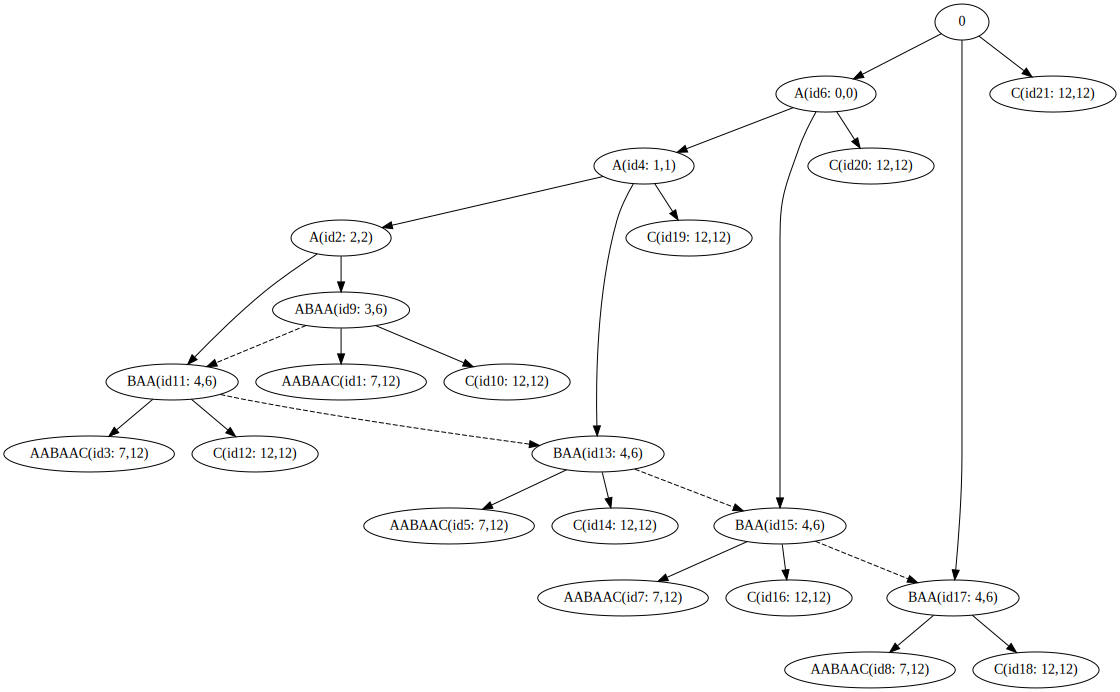

In [180]:
s = "xyzxyaxyz$"
s1 ="mississi$"
s2= "rattatattata$"
s3 = "AAAABAAAABAAC"
s4= "xxxyxx$"
s5="abaaba$"

st = SuffixTree()
st.insertAll(s3, verbose=True)
st.printTree(s3)